<a href="https://colab.research.google.com/github/DANCAR1969/programacion/blob/master/NPL_sec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#import librarys
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout, Bidirectional, BatchNormalization
from tensorflow.keras.optimizers import Adam
from imblearn.over_sampling import RandomOverSampler
from collections import Counter


In [ ]:
data = pd.read_csv('/content/emotion_dataset.csv')
data.head()

,text,label
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [ ]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'http\S+','',text)
    text = re.sub(r'@\w+','',text)
    text = re.sub(r'#\w+','', text)
    text = re.sub(r'[^a-z\s]','',text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

data['text'] = data['text'].astype(str).apply(preprocess_text)

In [ ]:
label_encoder = LabelEncoder()
data['label'] = label_encoder.fit_transform(data['label'])
data.head()

,text,label
0,i didnt feel humiliated,3
1,i can go from feeling so hopeless to so damned...,3
2,im grabbing a minute to post i feel greedy wrong,0
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,0


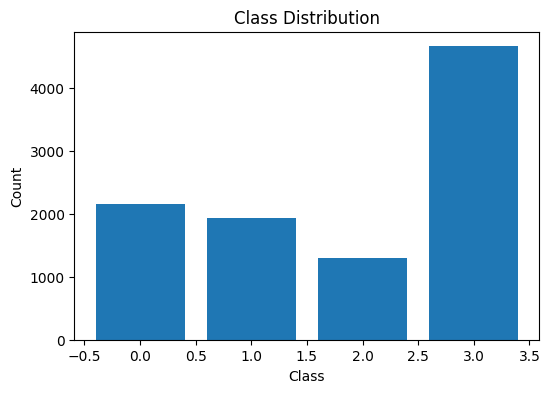

In [ ]:
plt.figure(figsize=(6,4))
plt.bar(Counter(data['label']).keys(), Counter(data['label']).values())
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['text'])
vocab_size = len(tokenizer.word_index) + 1
max_length =100

X = tokenizer.texts_to_sequences(data['text'])
X = pad_sequences(X, maxlen=max_length, padding='post')
y = data['label'].values

In [ ]:
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)

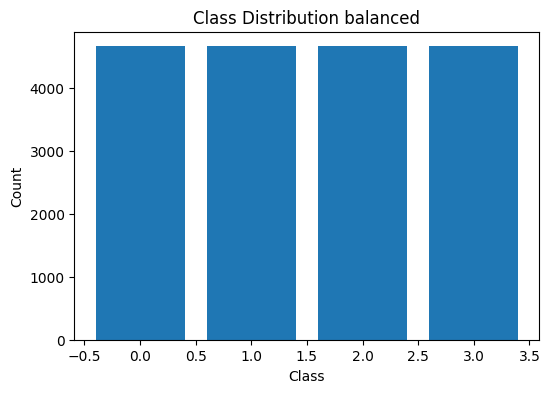

In [ ]:
plt.figure(figsize=(6,4))
plt.bar(Counter(y_resampled).keys(), Counter(y_resampled).values())
plt.title('Class Distribution balanced')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [ ]:
model = Sequential([
  Embedding(input_dim=vocab_size, output_dim=200, input_length=max_length),
  Bidirectional(LSTM(128, return_sequences=True)),
  BatchNormalization(),
  Dropout(0.3),
  Bidirectional(LSTM(64)),
  BatchNormalization(),
  Dropout(0.3),
  Dense(12, activation='relu'),
  BatchNormalization(),
  Dense(len(np.unique(y_resampled)), activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
history = model.fit(X_train, y_train, validation_split=0.1, epochs=3, batch_size=32, verbose=1)

Epoch 1/3
420/420 ━━━━━━━━━━━━━━━━━━━━ 268s 613ms/step - accuracy: 0.3342 - loss: 1.4590 - val_accuracy: 0.7162 - val_loss: 0.7417
Epoch 2/3
420/420 ━━━━━━━━━━━━━━━━━━━━ 264s 630ms/step - accuracy: 0.9354 - loss: 0.2465 - val_accuracy: 0.9485 - val_loss: 0.1781
Epoch 3/3
420/420 ━━━━━━━━━━━━━━━━━━━━ 320s 624ms/step - accuracy: 0.9794 - loss: 0.0873 - val_accuracy: 0.9471 - val_loss: 0.1659


In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_acc * 100:.2f}%')

117/117 ━━━━━━━━━━━━━━━━━━━━ 20s 171ms/step - accuracy: 0.9514 - loss: 0.1577
Test Accuracy: 94.75%


In [ ]:
import joblib

model.save('emotion_model.h5')
joblib.dump(tokenizer, 'tokenizer.jb')
joblib.dump(label_encoder, 'label_encoder.jb')

['label_encoder.jb']

In [ ]:
import joblib

model.save('emotion_model.h5')
joblib.dump(tokenizer, 'tokenizer.jb')
joblib.dump(label_encoder, 'label_encoder.jb')

['label_encoder.jb']

In [ ]:
import joblib as jb
from tensorflow import keras # Import the keras module

# Load the Keras model using keras.models.load_model
model = keras.models.load_model("emotion_model.h5")
tokenizer = jb.load("tokenizer.jb")
label_encoder = jb.load("label_encoder.jb")